### 第一版本 本部分代码中对于激活函数$\sigma$ (ax+b)中的x没有进行归一化，理论上效果应该不如文中的，在取rn如文中的方式时出现了很有意思的拟合高频，不拟合低频的情况，取rn为文中的导数，或取一时可以得到较好的结果

In [1]:
import torch
import torch.nn as nn
import numpy as np
import scipy.optimize
import matplotlib.pyplot as plt
import random

Consider the one-dimensional Helmholtz equation with the Dirichlet boundary condition over $\Omega=[0,8]$ :
$$
\left\{\begin{array}{l}
\frac{\mathrm{d}^2 u(x)}{\mathrm{d} x^2}+\lambda u(x)=f(x), \quad x \in \Omega, \\
u(0)=c_1, \quad u(8)=c_2,
\end{array}\right.
$$
where the wave number $\lambda=4$. We choose the exact solution
$$
u(x)=\sin \left(3 \pi x+\frac{3 \pi}{20}\right) \cos \left(2 \pi x+\frac{\pi}{10}\right)+2
$$

In [2]:
def Helmholtz_exact(x):
    #Return the exact solution
    u=np.sin(3*np.pi*x+3*np.pi/20)*np.cos(2*np.pi*x+np.pi/10)+2
    return u
def f(x):
    # to construct b from equation
    y=np.pi*(x+1/20)
    temp_d=np.pi**2*(-13*np.sin(3*y)*np.cos(2*y)-12*np.cos(3*y)*np.sin(2*y))
    temp_lambda=4*Helmholtz_exact(x)
    f=temp_d+temp_lambda
    return f

# import partion of unity function to fit variations
def PoU_a(x):
    if -1<=x<=1:
        y=1
    else:
        y=0
    return y
def PoU_b(x):
    if -5/4<=x<-3/4:
        y=(1+np.sin(2*np.pi*x))/2
    elif -3/4<=x<3/4:
        y=1
    elif 3/4<=x<5/4:
        y=(1-np.sin(2*np.pi*x))/2
    else:
        y=0
    return y
def PoU_b_1(x):
    if -5/4<=x<-3/4:
        y=np.pi*np.cos(2*np.pi*x)
    elif 3/4<=x<5/4:
        y=-np.pi*np.cos(2*np.pi*x)
    else:
        y=0
    return y
def PoU_b_2(x):
    if -5/4<=x<-3/4:
        y=-2*(np.pi)**2*np.sin(2*np.pi*x)
    elif 3/4<=x<5/4:
        y=2*(np.pi)**2*np.sin(2*np.pi*x)
    else:
        y=0
    return y
def tanh_1(x):
    y=1-np.tanh(x)**2
    return y
def tanh_2(x):
    y=2*np.tanh(x)**3-2*np.tanh(x)
    return y

In [3]:
# Parameters
M=1600
J=50
Mp=M/J
x_PoU=np.arange(Mp)+1
x_PoU=8*(2*x_PoU-1)/(2*Mp)
rn=8/(2*Mp)
rn=1/rn  #版本一中关于rn的选取，这么选会好很多，否则只能对高频信息进行拟合
rn=1     #版本一中关于rn=1结果更好
Q=1600

In [4]:
np.random.seed(2025)
A_matrix=np.random.uniform(-1, 1, size=(int(Mp),J))
A=np.reshape(A_matrix, (1,M), order='C')
np.random.seed(302)
B_matrix=np.random.uniform(-1, 1, size=(int(Mp),J))
B=np.reshape(B_matrix, (1,M), order='C')


#np.random.seed(2025302) 
#x_sample=np.random.uniform(0, 8, size=(1,Q))  
#x_sample=x_sample[0]   #随机采样点

x_sample=np.linspace(0,8,Q) #按照文中等距选采样点

In [5]:
#利用微分方程信息构建方程 Q代表采样点个数 M代表神经元个数=Mp*Jn

#特征函数在内点
Phi_in=np.zeros((Q, M))
b_in=np.zeros((Q,1))
for i in range(Q):
    x=x_sample[i]
    b_in[i]=f(x)
    for j in range(M):
        #count which psi to use
        p_count=int(j/J)
        xn=x_PoU[p_count]
        #二阶微分项
        temp_1=2*(1/rn)*A[0,j]*PoU_b_1((x-xn)/rn)*tanh_1(A[0,j]*x+B[0,j])+A[0,j]**2*PoU_b((x-xn)/rn)*tanh_2(A[0,j]*x+B[0,j])+(1/rn)**2*PoU_b_2((x-xn)/rn)*np.tanh(A[0,j]*x+B[0,j])
        #零阶项
        temp_2=4*PoU_b((x-xn)/rn)*np.tanh(A[0,j]*x+B[0,j])  #版本一
        
        #x_hat=(x-xn)/rn
        #temp_1=2*(1/rn)**2*A[0,j]*PoU_b_1(x_hat)*tanh_1(A[0,j]*x_hat+B[0,j])+(1/rn)**2*A[0,j]**2*PoU_b(x_hat)*tanh_2(A[0,j]*x_hat+B[0,j])+(1/rn)**2*PoU_b_2(x_hat)*np.tanh(A[0,j]*x_hat+B[0,j])
        #temp_2=4*PoU_b(x_hat)*np.tanh(A[0,j]*x_hat+B[0,j])    #版本二
        
        Phi_in[i,j]=temp_1+temp_2 


#特征函数在边界点
Phi_bd=np.zeros((2, M))
b_bd=np.zeros((2,1))
x_bd=np.array([0,8])
for i in range(2):
    x=x_bd[i]
    b_bd[i]=Helmholtz_exact(x)
    for j in range(M):
        #count which psi to use
        p_count=int(j/J)
        xn=x_PoU[p_count]
        
        Phi_bd[i,j]=PoU_b((x-xn)/rn)*np.tanh(A[0,j]*x+B[0,j])  #版本一
        #Phi_bd[i,j]=PoU_b((x-xn)/rn)*np.tanh(A[0,j]*(x-xn)/rn+B[0,j])   #版本二

In [6]:
###rescale
for i in range(Q):
    rescale=np.max(abs(Phi_in[i]))
    #rescale=1
    Phi_in[i]=Phi_in[i]/rescale
    b_in[i]=b_in[i]/rescale
for i in range(2):
    rescale=np.max(abs(Phi_bd[i]))
    #rescale=1
    Phi_bd[i]=Phi_bd[i]/rescale
    b_bd[i]=b_bd[i]/rescale

#### rescale用来调整边界和内点在优化中的权值(具体效果有待考证)
#### 上方代码块中两处rescale注释掉即为进行rescale

In [7]:
Phi=np.vstack((Phi_in, Phi_bd))
b=np.vstack((b_in, b_bd))

In [8]:
u=np.linalg.lstsq(Phi,b,rcond=None)[0]

In [9]:
# get the machine learning solution
def Helmholtz_machine(x):
    y=0
    for i in range(int(Mp)):
        xn=x_PoU[i]
        psi=PoU_b((x-xn)/rn)
        temp=0
        for j in range(J):
            index=i*J+j
            temp=temp+u[index]*np.tanh(A[0,index]*x+B[0,index])  #版本一
            #temp=temp+u[index]*np.tanh(A[0,index]*(x-xn)/rn+B[0,index])   #版本二
        y=y+psi*temp
    return y

In [10]:
Q_dense=Q*1
x_line=np.linspace(0,8,Q_dense)
y_line=np.zeros(Q_dense)
y_exact=np.zeros(Q_dense)
for i in range(Q_dense):
    y_line[i]=Helmholtz_machine(x_line[i])
    y_exact[i]=Helmholtz_exact(x_line[i])

L_inf_error= 0.0002891401985156694


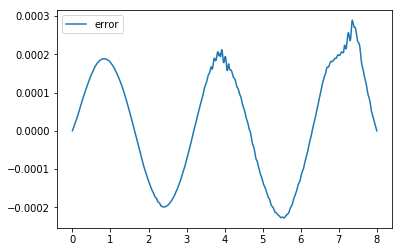

In [11]:
#plt.plot(x_line,y_line,label='learning solution')
#plt.plot(x_line,y_exact,label='exact solution')
plt.plot(x_line,y_exact-y_line,label='error')
plt.legend()
print('L_inf_error=',np.max(abs(y_exact-y_line)))

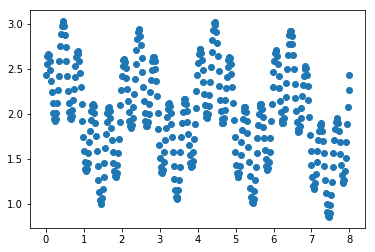

In [13]:
y_sample=np.zeros(Q)
for i in range(Q):
    y_sample[i]=Helmholtz_machine(x_sample[i])
plt.scatter(x_sample.T,y_sample)

In [328]:
x_selcet=x_sample[2]
delta=0.001 # not too little because of trunction error
d_2=(Helmholtz_machine(x_selcet+delta)+Helmholtz_machine(x_selcet-delta)-2*Helmholtz_machine(x_selcet))/(delta**2)
d_2+4*Helmholtz_machine(x_selcet)-b[2]
# this means the matrix caculates right

array([81.56374415])

In [327]:
u

array([[-3.18040661e+09],
       [-2.02401413e+10],
       [-8.21312431e+09],
       ...,
       [ 2.78021177e+09],
       [-3.56547825e+09],
       [ 1.57687342e+10]])

In [248]:
b[2]

array([-23.67482404])

In [329]:
np.max(abs(np.dot(Phi,u)-b))

0.7407853628852894

In [250]:
np.linalg.matrix_rank(Phi)

238

In [17]:
f(1)

94.28069314535387